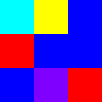

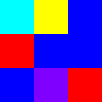

Эталонное изображение:
Достигнута требуемая точность на поколении 3

Финальный результат после 3 поколений:

Процесс эволюции:


([5 3 6; 1 6 6; 6 7 1], [5 3 6; 1 6 6; 6 7 1])

In [22]:
using Random
using Images
using FileIO
using Base64

# Палитра цветов радуги (7 цветов)
function get_rainbow_palette()
    return [
        RGB(1.0, 0.0, 0.0),     # красный
        RGB(1.0, 0.5, 0.0),     # оранжевый
        RGB(1.0, 1.0, 0.0),     # желтый
        RGB(0.0, 1.0, 0.0),     # зеленый
        RGB(0.0, 1.0, 1.0),     # голубой
        RGB(0.0, 0.0, 1.0),     # синий
        RGB(0.5, 0.0, 1.0)      # фиолетовый
    ]
end

# Преобразование матрицы в изображение
function matrix_to_image(matrix, palette)
    h, w = size(matrix)
    img = Array{RGB{Float64}}(undef, h, w)
    for i in 1:h
        for j in 1:w
            idx = clamp(matrix[i, j], 1, length(palette))
            img[i, j] = palette[idx]
        end
    end
    return img
end

# Преобразование матрицы в бинарный формат (3 бита на элемент)
function matrix_to_binary(matrix, bits_per_element=3)
    binary_vec = Bool[]
    for elem in matrix
        val = elem - 1  # приводим к диапазону 0-6
        for i in (bits_per_element-1):-1:0
            push!(binary_vec, val & (1 << i) != 0)
        end
    end
    return binary_vec
end

# Преобразование бинарного формата в матрицу
function binary_to_matrix(binary_vec, bits_per_element, matrix_size)
    matrix = zeros(Int, matrix_size)
    for i in 1:prod(matrix_size)
        bits = binary_vec[(i-1)*bits_per_element+1:i*bits_per_element]
        val = sum(bits .* [4, 2, 1])  # преобразуем 3 бита в число 0-7
        matrix[i] = clamp(val + 1, 1, 7)  # приводим к диапазону 1-7
    end
    return matrix
end

# Кроссовер (равномерный)
function crossover(a, b)
    child = similar(a)
    for i in eachindex(a)
        child[i] = rand() < 0.5 ? a[i] : b[i]
    end
    return child
end

# Мутация (инвертируем биты с заданной вероятностью)
function mutate(binary_vec, mutation_rate=0.01)
    mutated = copy(binary_vec)
    for i in eachindex(mutated)
        if rand() < mutation_rate
            mutated[i] = !mutated[i]
        end
    end
    return mutated
end

# Функция для отображения GIF в Jupyter
function show_gif(frames, fps=2; display_size=400)
    # Сохраняем оригинальный размер (без сжатия)
    temp_file = tempname() * ".gif"
    save(temp_file, cat(frames..., dims=3), fps=fps)
    
    # Отображаем с фиксированным размером пикселей
    w, h = size(frames[1])
    aspect_ratio = w/h
    display_width = display_size
    display_height = round(Int, display_size / aspect_ratio)
    
    display("text/html", """
    <div style="width:$(display_width)px; height:$(display_height)px; image-rendering: pixelated;">
        <img src="data:image/gif;base64,$(base64encode(open(read, temp_file)))" 
             width="$(display_width)" height="$(display_height)"
             style="image-rendering: pixelated;">
    </div>
    """)
end

# Основной генетический алгоритм
function genetic_algorithm(;
        matrix_size=(3, 3),
        epsilon=0.1,
        max_generations=1000,
        mutation_rate=0.01,
        use_hamming=true)
    
    palette = get_rainbow_palette()
    bits_per_element = 3
    
    # 1. Генерация эталонной и начальной матриц
    reference = rand(1:7, matrix_size)
    current = rand(1:7, matrix_size)
    
    # 2. Подготовка кадров для анимации
    frames = [matrix_to_image(current, palette)]
    
    # 3. Преобразование в бинарный формат
    ref_bin = matrix_to_binary(reference, bits_per_element)
    current_bin = matrix_to_binary(current, bits_per_element)
    
    # 4. Вывод эталонного изображения
    println("Эталонное изображение:")
    display(matrix_to_image(reference, palette))
    
    # 5. Основной цикл генетического алгоритма
    generation = 0
    while generation < max_generations
        # Создание потомка
        child_bin = crossover(current_bin, ref_bin)
        child_bin = mutate(child_bin, mutation_rate)
        child = binary_to_matrix(child_bin, bits_per_element, matrix_size)
        
        # Расчет расстояния
        if use_hamming
            dist = sum(current .!= reference)
            new_dist = sum(child .!= reference)
        else
            dist = sqrt(sum((current .- reference).^2))
            new_dist = sqrt(sum((child .- reference).^2))
        end
        
        # Отбор
        if new_dist < dist
            current = child
            current_bin = child_bin
            push!(frames, matrix_to_image(current, palette))
        end
        
        # Условие остановки
        if new_dist < epsilon
            println("Достигнута требуемая точность на поколении $generation")
            break
        end
        
        generation += 1
    end
    
    # 6. Вывод результатов
    println("\nФинальный результат после $generation поколений:")
    display(matrix_to_image(current, palette))
    
    # 7. Отображение анимации
    println("\nПроцесс эволюции:")
    show_gif(frames)
    
    return reference, current
end

# Запуск алгоритма с параметрами по умолчанию
genetic_algorithm(use_hamming=false, epsilon=0.5, max_generations=500)